In [64]:
import os
# Ensure the working directory is set to the project root
os.chdir('/Users/sudishmakarki/My_project2')
print("Current working directory:", os.getcwd())

# Now import your modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from models.data_interpolation import load_data, preprocess_data

sns.set(style="whitegrid")

Current working directory: /Users/sudishmakarki/My_project2


In [65]:
# Notebook Cell 2: Load and preprocess data
df = load_data(filepath='data/RestaurantData.csv')
df_full = preprocess_data(df)
# Optional: use df alias for consistency in visualization code
df = df_full.copy()


                     Year  Month  Season  DayOfWeek WeekDay  Hour  \
Timestamp                                                           
2018-01-01 00:00:00  2018      1  Winter          1  Monday     0   
2018-01-01 01:00:00  2018      1  Winter          1  Monday     1   
2018-01-01 02:00:00  2018      1  Winter          1  Monday     2   
2018-01-01 03:00:00  2018      1  Winter          1  Monday     3   
2018-01-01 04:00:00  2018      1  Winter          1  Monday     4   

                            Holiday Weather SpecialEvent  CustomerCount  \
Timestamp                                                                 
2018-01-01 00:00:00  New Year's Day   Rainy          NaN              6   
2018-01-01 01:00:00  New Year's Day   Windy          NaN             11   
2018-01-01 02:00:00  New Year's Day   Snowy          NaN              9   
2018-01-01 03:00:00  New Year's Day   Rainy          NaN             10   
2018-01-01 04:00:00  New Year's Day  Cloudy          NaN          

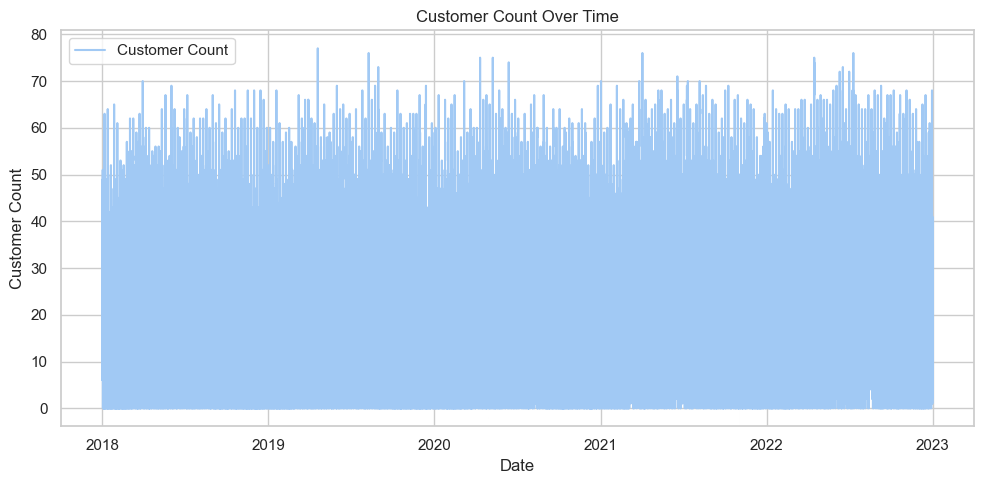

In [67]:
# 1. Time Series Plot: Customer Count Over Time
pastel_colors = sns.color_palette("pastel")
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['CustomerCount'], 
         label='Customer Count', 
         color=pastel_colors[0])  # Uses the first pastel color
plt.title("Customer Count Over Time")
plt.xlabel("Date")
plt.ylabel("Customer Count")
plt.legend()
plt.tight_layout()
plt.show()

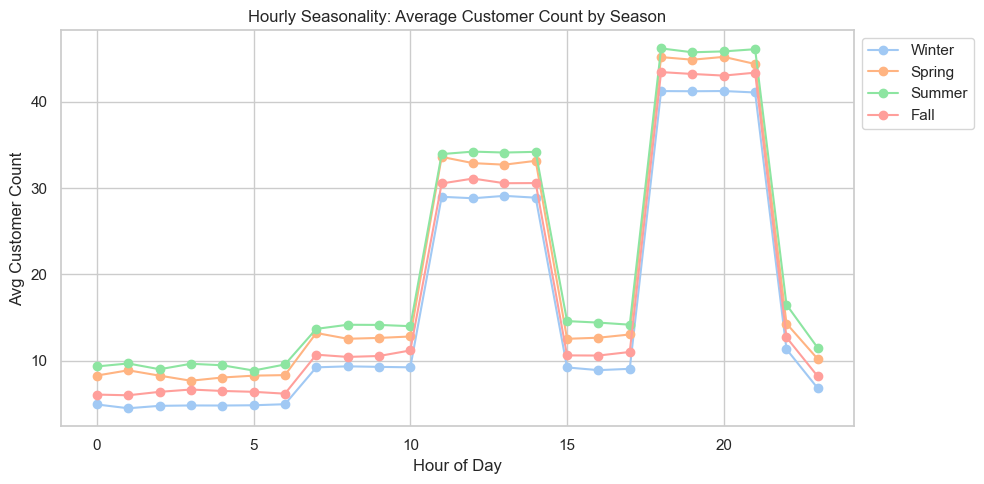

In [68]:
#2. Calculate hourly averages grouped by season
hourly_avg = df.groupby(['Season', df.index.hour])['CustomerCount'].mean().reset_index()
hourly_avg.columns = ['Season', 'Hour', 'AvgCustomerCount']

# Define the order of seasons and assign pastel colors
seasons_order = ['Winter', 'Spring', 'Summer', 'Fall']
colors = sns.color_palette("pastel", len(seasons_order))

# Create the plot
fig, ax = plt.subplots(figsize=(10, 5))

for i, season in enumerate(seasons_order):
    season_data = hourly_avg[hourly_avg['Season'] == season]
    ax.plot(season_data['Hour'], season_data['AvgCustomerCount'],
            marker='o',
            color=colors[i],
            label=season)

ax.set_title("Hourly Seasonality: Average Customer Count by Season")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Avg Customer Count")
ax.grid(True)
ax.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

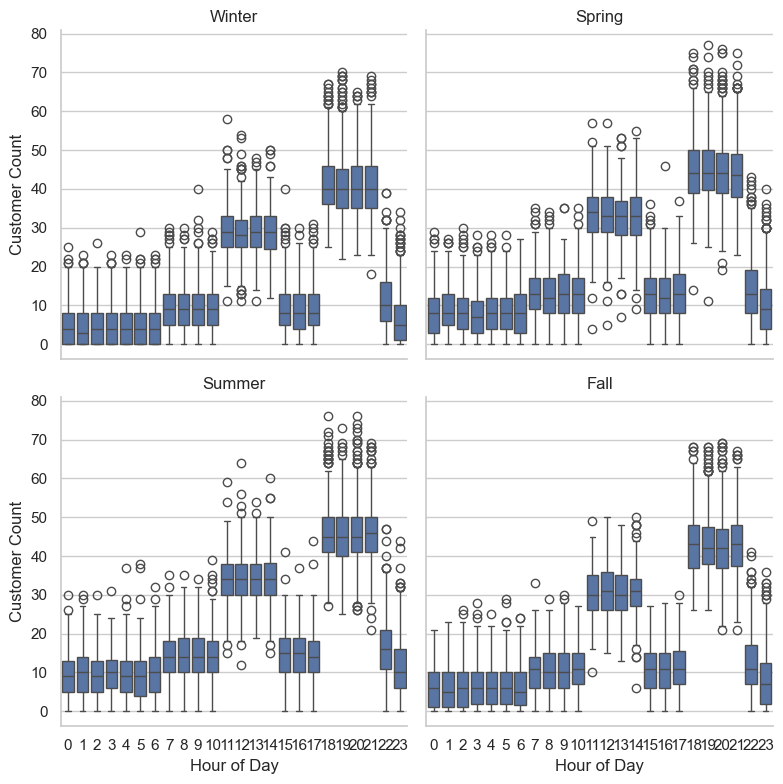

In [69]:
#3. Seasonal or Monthly Subplots
df['Hour'] = df.index.hour

# Create a FacetGrid of box plots for each season
plt.figure(figsize=(12, 6))
g = sns.FacetGrid(df, col="Season", col_wrap=2, height=4, sharey=True)
g.map_dataframe(sns.boxplot, x="Hour", y="CustomerCount", order=sorted(df['Hour'].unique()))
g.set_axis_labels("Hour of Day", "Customer Count")
g.set_titles("{col_name}")
plt.tight_layout()
plt.show()


In [ ]:
#4. Multiple scatter plots for hours, week, month and year
# Optionally set a style for a grid-like background
plt.style.use('ggplot')

# Get all unique hour values, sorted
hour_values = sorted(df['Hour'].unique())

sns.pairplot(
    data=df.dropna(subset=['Hour', 'DayOfWeek', 'Month', 'Year', 'CustomerCount']),
    hue='Hour',                # Uses the original 'Hour' column
    hue_order=hour_values,     # Force Seaborn to treat Hour as discrete categories
    palette='Spectral',        # Vibrant color palette
    x_vars=['Hour', 'DayOfWeek', 'Month', 'Year'],
    y_vars=['CustomerCount'],
    height=5,
    plot_kws={'alpha': 0.15, 'linewidth': 0}  # style settings
)

plt.suptitle('Customer Count by Hour, Day of Week, Month, and Year', y=1)
plt.show()